In [1]:
#pip install pycocotools

[OBJECT DETECT MODEL - Faster R-CNN]  
- 데이터셋 : cocodataset  
- 카테고리 : 

In [29]:
## 모듈 로딩
import os
from PIL import Image

import torch
from pycocotools.coco import COCO					## COCODataser 사용 위한 API
from torch.utils.data import Dataset, DataLoader	## Pytorch의 데이터셋 관련
from torchvision import transforms					## 이미지 데이터 전처리 위한 모듈

import matplotlib.pyplot as plt						## 시각화
import matplotlib.patches as patches				## 이미지 상에 추가 그래프 관련
from PIL import Image								## 이미지 데이터 처리 모듈
import numpy as np 

In [ ]:
## 데이터 준비
DATA_DIR = '../data/image/coco/'

[1] 데이터세트 클래스 선언

In [ ]:
class COCODataset(Dataset):
	## -----------------------------------------------------------------------------------
	## - 필수 오버라이딩 메서드
	## -----------------------------------------------------------------------------------
	## -----------------------------------------------------------------------------------
	## 메서드이름 : _init_
	## 매개변수들 : root 		데이터가 존재하는 경로
	## 			  train		  학습용 또는 검증용 식별 위한
	##			  transform   이미지 전처리 인스턴스 지정
	## -----------------------------------------------------------------------------------
	def __init__(self, root, train, transform=None):
		super().__init__()
		## 실제 이미지 경로
		directory = 'train' if train else 'val'
		## 이미지 내의 존재 객체 정보 추출
		annotations = os.path.join(root, 
							 	  'annotations', 
								  f'{directory}_annotations.json')

		## 데이터 추출 위한 속성들
		self.coco = COCO(annotations)						## train/val_annotation.json 읽어서 dict로 저장
															## - self.dataset	
															## - self.anns 이미지병 부가정보들
															## - self.cats 데이터셋의 카테고리 정보
															## - self.imgs 이미지지
		self.image_path = os.path.join(root, directory)		
		self.transform = transform
		##	클래스 내부에서만 사용되는 메서드 호출 => self.메서드명()
		self.categories = self._get_categories() ## 해당 데이터셋의 카테고리 IDX_TO_NAME
		self.data = self._load_data()
		
	## ------------------------------------------------------------------------------------
	## 메서드기능 : 

	def _get_categories(self):
		categories = {0: "background"}
		for category in self.coco.cats.values():
			categories[category["id"]] = category["name"]
		return categories
	
	# COCO 데이터세트 불러오기

	## 반환결과값: 이미지데이터와 타겟을 
	def _load_data(self):
		data = []
		for _id in self.coco.imgs:
			## 이미지 데이터 로딩------------------------------------------------------------
			file_name = self.coco.loadImgs(_id)[0]["file_name"]
			## 실제 이미지 경로 추출
			image_path = os.path.join(self.image_path, file_name)
			## 이미지 로우 데이터 추출
			image = Image.open(image_path).convert("RGB")

			## 이미지 내 객체의 위치와 이미지 클래스 저장---------------------------------------
			boxes = []
			labels = []
			## 이미지에 연동된 어노테이션 리스트 추출
			anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
			## 이미지 내에 객체 위치와 카테고리 정보 추출
			for ann in anns:
				x, y, w, h = ann["bbox"]
				boxes.append([x, y, x + w, y + h])
				labels.append(ann["category_id"])

			## 이미지의 타겟 정보 즉, 아이디, 박스위치, 클래스 정보
			target = {
				"image_id": torch.LongTensor([_id]),
				"boxes": torch.FloatTensor(boxes),
				"labels": torch.LongTensor(labels)
			}
			data.append([image, target])
		return data
	
	# 호출 및 길이 반환 메서드
	def __getitem__(self, index):
		image, target = self.data[index]
		if self.transform:
			image = self.transform(image)
		return image, target
	
	def __len__(self):
		return len(self.data)
	

[2] 데이터 전처리 준비 <hr>

In [30]:
## 이미지 전처리 관련 인스턴스
## - 이미지 텐서화 및 타입 설정
transform = transforms.Compose(
	[
		transforms.PILToTensor(),						## PIL의 Image 객체를 텐서화
		transforms.ConvertImageDtype(dtype=torch.float)	## Image 텐서 타입 설정
	]
)

[2] COCO 데이터세트 불러오기

In [ ]:
def _load_data(self):
    data = []
    for _id in self.coco.imgs:
        file_name = self.coco.loadImgs(_id)[0]["file_name"]
        image_path = os.path.join(self.image_path, file_name)
        image = Image.open(image_path).convert("RGB")

        boxes = []
        labels = []
        anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        target = {
            "image_id": torch.LongTensor([_id]),
            "boxes": torch.FloatTensor(boxes),
            "labels": torch.LongTensor(labels)
        }
        data.append([image, target])
    return data



[3] 호출 및 길이 반환 메서드

In [12]:
def __getitem__(self, index):
	image, target = self.data[index]
	if self.transform:
		image = self.transform(image)
	return image, target

In [16]:
def __len__(self):
	return len(self.data)

[4] 데이터로더

In [ ]:
def collator(batch):
    return tuple(zip(*batch))

transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)
## 학습용, 테스트용 데이터셋 셍성
trainDS = COCODataset(DATA_DIR, train=True, transform=transform)
testDS = COCODataset(DATA_DIR, train=False, transform=transform)

train_dataloader = DataLoader(
    trainDS, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator)

test_dataloader = DataLoader(
    testDS, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
## 클래스 변환 DICT 생성
IDX_TO_CATEGORY = trainDS.categories  
IDX_TO_CATEGORY

{0: 'background', 1: 'cat', 2: 'dog'}

In [24]:
print(f'[trainDS] 개수 : {len(train_dataloader)}개')
print(f'[testDS] 개수 : {len(test_dataloader)}개')

[trainDS] 개수 : 607개
[testDS] 개수 : 181개


In [ ]:
# 첫 번째 배치 가져오기
batch = next(iter(train_dataloader))

# unpack
ImgTS_batch, targetdict_batch = batch

# 배치 크기 4니까 첫 번째 이미지와 타겟만 보기
ImgTS = ImgTS_batch[0]
targetdict = targetdict_batch[0]

## 학습용 데이터
print(ImgTS.shape, targetdict.keys())

# 라벨 정보 추출
label = targetdict['labels'].item()

# 박스 정보 추출
lx, ly, rx, ry = [round(data.item()) for data in targetdict['boxes'].reshape(-1)]
w, h = rx - lx, ry - ly

print(f'lx, ly, rx, ry => {lx, ly, w, h}')


torch.Size([3, 640, 513]) dict_keys(['image_id', 'boxes', 'labels'])
lx, ly, rx, ry => (20, 2, 493, 424)


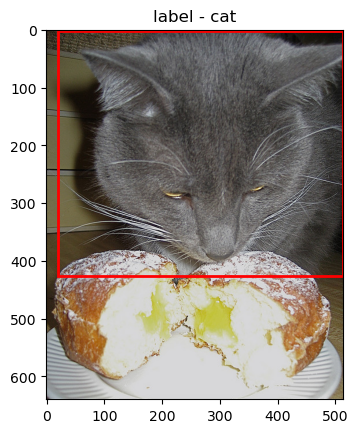

In [27]:
## 시각화 및 바운딩 박스
plt.imshow(ImgTS.permute(1,2,0))
plt.title(f'label - {IDX_TO_CATEGORY[label]}')

## - 바운딩 박스 추가
ax = plt.gca()	# - get current axis
ax.add_patch(patches.Rectangle((lx, ly), w, h, color='red', linewidth=2, fill=False))
plt.show()

[3] 모델 정의 및 설계 <hr>
- 모델 네트워크 구성
	- Backbone Network : VGG16
	- Nect Network : RPN
	- Head Network : Faster R-CNN

In [32]:
## 모델 관련 모듈 로딩
from torchvision.models import vgg16, VGG16_Weights				## 성능 개선 위해 변경 가능
from torchvision.models.detection import rpn, FasterRCNN
from torchvision import ops

In [ ]:
##